In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os, os.path
import glob
import pickle
import numpy
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate
import matplotlib
matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleIsochroneApprox
from galpy.util import bovy_conversion, bovy_plot, save_pickles, bovy_coords
import pal5_util
from gd1_util import R0, V0
import run_pal5_abc
import custom_stripping_df
import bispectrum
import seaborn as sns
from matplotlib import cm, pyplot
from matplotlib.ticker import FuncFormatter, NullFormatter
%pylab inline
scaling= 'spectrum'
save_figures= False
minxi= 0.25

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


# Analysis of simulations with stream peppering for a Pal5 like stream in observed space

Bunch of code to convert to Pal 5 observed frame:

In [3]:
# Load the smooth and peppered stream, only need 1 time-sampling, 
# bc only use it to convert to obs. space at present
sdf_smooth= pal5_util.setup_pal5model()
pepperfilename= 'pal5pepper1sampling.pkl'
if os.path.exists(pepperfilename):
    with open(pepperfilename,'rb') as savefile:
        sdf_pepper= pickle.load(savefile)
else:
    import simulate_streampepper
    timpacts= simulate_streampepper.parse_times('1sampling',9.)
    sdf_pepper= pal5_util.setup_pal5model(timpact=timpacts,
                                        hernquist=True)
    save_pickles(pepperfilename,sdf_pepper)

In [4]:
# Convert track to xi, eta
trackRADec=\
  bovy_coords.lb_to_radec(sdf_smooth._interpolatedObsTrackLB[:,0],
                          sdf_smooth._interpolatedObsTrackLB[:,1],
                          degree=True)
trackXiEta=\
  pal5_util.radec_to_pal5xieta(trackRADec[:,0],
                    trackRADec[:,1],degree=True)
smooth_track= []
for coord in range(6):
    if coord < 2:
        smooth_track.append(\
            interpolate.InterpolatedUnivariateSpline(sdf_smooth._interpolatedThetasTrack,
                                                     trackXiEta[:,coord]))
    else:
        smooth_track.append(\
            interpolate.InterpolatedUnivariateSpline(sdf_smooth._interpolatedThetasTrack,
                                                     sdf_smooth._interpolatedObsTrackLB[:,coord]))
smooth_ll= interpolate.InterpolatedUnivariateSpline(trackXiEta[:,0],
                                                    sdf_smooth._interpolatedThetasTrack)
def convert_dens_to_obs(apars,dens,dens_smooth,mO,poly_deg=3):
    """
    NAME:
        convert_dens_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        dens - density(apars)
        dens_smooth - smooth-stream density(apars)
        mO= (None) mean parallel frequency (1D) 
            [needs to be set to get density on same grid as track]
        poly_deg= (3) degree of the polynomial to fit for the 'smooth' stream
    OUTPUT:
        (xi,dens/smooth)
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    mradec= bovy_coords.lb_to_radec(mT[0],mT[1],degree=True)
    mxieta= pal5_util.radec_to_pal5xieta(mradec[:,0],mradec[:,1],degree=True)
    outll= numpy.arange(minxi,14.35,0.1)
    # Interpolate density
    ipll= interpolate.InterpolatedUnivariateSpline(mxieta[:,0],apars)
    ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens/dens_smooth)
    return (outll,ipdens(ipll(outll)))
def convert_track_to_obs(apars,mO,coord):
    """
    NAME:
        convert_track_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        mO - mean parallel frequency (1D)
        coord - coordinate to convert to (1: eta, 2: distance, 3: vlos, 4: pmll, 5: pmbb)
    OUTPUT:
        (longitude,(track-smooth)[coord])
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    mradec= bovy_coords.lb_to_radec(mT[0],mT[1],degree=True)
    mxieta= pal5_util.radec_to_pal5xieta(mradec[:,0],mradec[:,1],degree=True)
    mT[0]= mxieta[:,0]
    mT[1]= mxieta[:,1]
    # Interpolate
    ipll= interpolate.InterpolatedUnivariateSpline(mT[0],apars)
    ipcoord= interpolate.InterpolatedUnivariateSpline(apars,mT[coord])
    outll= numpy.arange(minxi,14.35,0.1)
    return (outll,ipcoord(ipll(outll))-smooth_track[coord](smooth_ll(outll)))    
def read_data(filename):
    data1= numpy.genfromtxt(filename,delimiter=',',max_rows=5002)
    # Search for batches
    batchfilenames= glob.glob(filename.replace('.dat','.*.dat'))
    for bfilename in batchfilenames:
        try:
            datab= numpy.genfromtxt(bfilename,delimiter=',')
        except: continue
        data1= numpy.vstack((data1,datab[2:]))
    return data1
def read_dens(filename,indx=None,rand=False,poly_deg=3):
    densdata= read_data(filename)
    mOfilename= filename.replace('dens','omega')
    mOdata= read_data(mOfilename)
    apars= densdata[0]
    nsim= len(densdata)-2 # first two are apar and smooth
    ll,tdata1= convert_dens_to_obs(apars,densdata[2],densdata[1],
                                   mOdata[2],poly_deg=poly_deg)
    if not indx is None:
        return convert_dens_to_obs(apars,densdata[2+indx],densdata[1],
                                   mOdata[2+indx])
    if rand:
        rindx= int(numpy.floor(numpy.random.uniform()*nsim))
        print rindx
        return convert_dens_to_obs(apars,densdata[2+rindx],densdata[1],
                                   mOdata[2+rindx])
    out= numpy.zeros((nsim,len(tdata1)))
    for ii in range(nsim):
        ll, tdata1= convert_dens_to_obs(apars,densdata[2+ii],densdata[1],
                                        mOdata[2+ii])
        out[ii]= tdata1
    return (ll,out)
def median_csd(filename,filename2=None,scatter=False,
              coord1=1,coord2=1,
              err1=None,err2=None,
              poly_deg=3):
    # Compute the median CSD, if filename2 is not None, compute cross
    data1= read_data(filename)
    if filename2 is None:
        data2= data1
    else:
        data2= read_data(filename2)
    if coord1 == 'dens':
        mOfilename= filename.replace('dens','omega')
        mOdata1= read_data(mOfilename)
    if coord2 == 'dens':
        if filename2 is None:
            mOdata2= mOdata1
        else:
            mOfilename2= filename2.replace('dens','omega')
            mOdata2= read_data(mOfilename2)
    apars= data1[0]
    nsim= len(data1)-2 # first two are apar and smooth
    if nsim < 1000:
        print "WARNING: Using fewer than 1,000 (%i) simulations to compute medians from %s" % (nsim,filename)
    if coord1 == 'dens':
        ll,tdata1= convert_dens_to_obs(apars,data1[2],data1[1],mOdata1[2],poly_deg=poly_deg)
    else:
        ll,tdata1= convert_track_to_obs(apars,data1[2],coord1)
    if coord2 == 'dens':
        ll,tdata2= convert_dens_to_obs(apars,data2[2],data2[1],mOdata2[2],poly_deg=poly_deg)
    else:
        ll,tdata2= convert_track_to_obs(apars,data2[2],coord2)
    px= signal.csd(tdata1,tdata2,fs=1./(ll[1]-ll[0]),scaling=scaling,nperseg=len(ll))[0]
    ppy= numpy.empty((nsim,len(px)))
    ppy_err= numpy.empty((nsim,len(px)))
    for ii in range(nsim):
        # convert
        if coord1 == 'dens':
            ll,tdata1= convert_dens_to_obs(apars,data1[2+ii],data1[1],mOdata1[2+ii],poly_deg=poly_deg)
        else:
            ll,tdata1= convert_track_to_obs(apars,data1[2+ii],coord1)
        if numpy.any(data1[2+ii] != data2[2+ii]):
            if coord2 == 'dens':
                ll,tdata2= convert_dens_to_obs(apars,data2[2+ii],data2[1],mOdata2[2+ii],poly_deg=poly_deg)
            else:
                ll,tdata2= convert_track_to_obs(apars,data2[2+ii],coord2)
            ppy[ii]= numpy.absolute(signal.csd(tdata1,tdata2,
                                               fs=1./(ll[1]-ll[0]),scaling=scaling,
                                               nperseg=len(ll))[1])
        else:
            ppy[ii]= signal.csd(tdata1,tdata1,
                                fs=1./(ll[1]-ll[0]),scaling=scaling,
                                nperseg=len(ll))[1].real
        # Same for errors
        if not err1 is None:
            tmock1= err1*numpy.random.normal(size=len(ll))
            if numpy.any(data1[2+ii] != data2[2+ii]):
                tmock2= err2*numpy.random.normal(size=len(ll))
                ppy_err[ii]= numpy.absolute(signal.csd(tmock1,tmock2,
                                                       fs=1./(ll[1]-ll[0]),scaling=scaling,
                                                       nperseg=len(ll))[1])
            else:
                ppy_err[ii]= signal.csd(tmock1,tmock1,
                                        fs=1./(ll[1]-ll[0]),scaling=scaling,
                                        nperseg=len(ll))[1].real
    # Following is the correct scaling in the sense that random noise gives same CSD no matter how long the stream
    if not scatter:
        return (1./px,numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(ll[-1]-ll[0])),
                numpy.sqrt(numpy.nanmedian(ppy_err,axis=0)*(ll[-1]-ll[0])))
    else:
        out= numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(ll[-1]-ll[0]))
        ppy.sort(axis=0)
        return (1./px,out,
                numpy.sqrt(ppy[int(numpy.round(0.25*nsim))]*(ll[-1]-ll[0])),
                numpy.sqrt(ppy[int(numpy.round(0.75*nsim))]*(ll[-1]-ll[0])),
                numpy.sqrt(numpy.nanmedian(ppy_err,axis=0)*(ll[-1]-ll[0])))

Code to plot power and cross-power spectra:

In [5]:
def plot_dens(filename,poly_deg=3,color=sns.color_palette()[0],zorder=1,ls='-',
              fill=False,fill_color='0.65',fill_zorder=0,
              err_color=sns.color_palette()[2],err_zorder=0,
              err=None,scale=1.,add_err=0.):
    px, py, py_err= median_csd(filename,coord1='dens',coord2='dens',
                               err1=err,poly_deg=poly_deg)
    py= numpy.sqrt(py**2.+add_err**2.)
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not err is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,scatter=True,
                                               coord1='dens',coord2='dens',
                                               poly_deg=poly_deg)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    return None
def plot_all_track(filename,color=sns.color_palette()[0],zorder=1,ls='-',
                   fill=False,fill_color='0.65',fill_zorder=0,
                   err_color=sns.color_palette()[2],err_zorder=0,
                   errs=[None,None,None],
                   scale=1.):
    subplot(1,3,1)
    px, py, py_err= median_csd(filename,coord1=1,err1=errs[0])
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not errs[0] is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,scatter=True,coord1=1)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    subplot(1,3,2)
    px, py, py_err= median_csd(filename,coord1=2,err1=errs[1])
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not errs[1] is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,scatter=True,coord1=2)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    subplot(1,3,3)
    px, py, py_err= median_csd(filename,coord1=3,err1=errs[2])
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not errs[2] is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,scatter=True,coord1=3)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    return None
def plot_all_track_dens(filename,color=sns.color_palette()[0],zorder=1,ls='-',
                        fill=False,fill_color='0.65',fill_zorder=0,
                        err_color=sns.color_palette()[2],err_zorder=0,
                        err1=None,err2s=[None,None,None],
                        scale=1.):
    subplot(1,3,1)
    px, py, py_err= median_csd(filename,filename2=filename.replace('dens','omega'),
                               coord1='dens',coord2=1,err1=err1,err2=err2s[0])
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not err2s[0] is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,filename2=filename.replace('dens','omega'),
                                               scatter=True,coord1='dens',coord2=1)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    subplot(1,3,2)
    px, py, py_err= median_csd(filename,filename2=filename.replace('dens','omega'),
                               coord1='dens',coord2=2,err1=err1,err2=err2s[1])
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not err2s[1] is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,filename2=filename.replace('dens','omega'),
                                               scatter=True,coord1='dens',coord2=2)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    subplot(1,3,3)
    px, py, py_err= median_csd(filename,filename2=filename.replace('dens','omega'),
                               coord1='dens',coord2=3,err1=err1,err2=err2s[2])
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not err2s[2] is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,filename2=filename.replace('dens','omega'),
                                               scatter=True,coord1='dens',coord2=3)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    return None
def set_ranges_and_labels_dens():
    bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$')
    ylim(0.01,10.)
    xlim(1.,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None
def set_ranges_and_labels():
    subplot(1,3,1)
    bovy_plot.bovy_text(r'$\sqrt{\eta\eta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$')
    ylim(0.001,1.)
    xlim(1.,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    subplot(1,3,2)
    bovy_plot.bovy_text(r'$\sqrt{DD}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$')
    ylim(0.001,1.)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    subplot(1,3,3)
    bovy_plot.bovy_text(r'$\sqrt{V_{\mathrm{los}} V_{\mathrm{los}}}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$')
    ylim(0.001,1.)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    return None
def set_ranges_and_labels_cross():
    subplot(1,3,1)
    bovy_plot.bovy_text(r'$\sqrt{|\delta b|}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$')
    ylim(0.001,10.)
    xlim(1.,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    subplot(1,3,2)
    bovy_plot.bovy_text(r'$\sqrt{|\delta D|}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$')
    ylim(0.001,10.)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    subplot(1,3,3)
    bovy_plot.bovy_text(r'$\sqrt{|\delta V_{\mathrm{los}}|}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$')
    ylim(0.001,10.)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    return None
def color_from_colormap(val,cmap,cmin,cmax):
    return cmap((val-cmin)/(cmax-cmin))
def add_colorbar_dens(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.775,0.135,0.05,0.815])
    else:
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.925, 0.13, 0.075, 0.83])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None
def add_colorbar(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.975, 0.13, 0.025, 0.83])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))



## The density data from Ibata et al. (2016)

In [6]:
# Read the data
backg= 400.
data= numpy.loadtxt('data/ibata_fig7b_raw.dat',delimiter=',')
sindx= numpy.argsort(data[:,0])
data= data[sindx]
data_lowerr= numpy.loadtxt('data/ibata_fig7b_rawlowerr.dat',delimiter=',')
sindx= numpy.argsort(data_lowerr[:,0])
data_lowerr= data_lowerr[sindx]
data_uperr= numpy.loadtxt('data/ibata_fig7b_rawuperr.dat',delimiter=',')
sindx= numpy.argsort(data_uperr[:,0])
data_uperr= data_uperr[sindx]
data_err= 0.5*(data_uperr-data_lowerr)

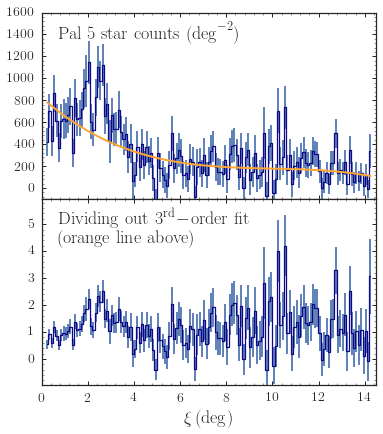

In [7]:
basefilename_pal5= os.path.join(os.getenv('DATADIR'),'streamgap-pepper','pal5_multtime')
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(6.,10*2./3.)
xrange=[0.,14.5]
# First plot the data
subplot(2,1,1)
tindx= (data[:,0] > 0.2)*(data[:,0] < 14.35)
bovy_plot.bovy_plot(data[tindx,0],data[tindx,1]-backg,
                    ls='steps-mid',color=cm.plasma(0.),lw=1.25,
                    gcf=True,xrange=xrange,
                    yrange=[-95.,1600.])
errorbar(data[tindx,0],data[tindx,1]-backg,data_err[tindx,1],
        marker='None',ls='None')
# Show continuum fits
pp= Polynomial.fit(data[tindx,0],data[tindx,1]-backg,
                   deg=3,w=1./data_err[tindx,1])
xxs= numpy.linspace(0.25,14.25,201)
plot(xxs,pp(xxs),'-',color=cm.plasma(0.8),lw=2.)
gca().xaxis.set_major_formatter(plt.NullFormatter())
bovy_plot.bovy_text(r'$\mathrm{Pal\ 5\ star\ counts\ (deg}^{-2})$',
                   top_left=True,size=18.)
subplot(2,1,2)
tindx= (data[:,0] > 0.2)*(data[:,0] < 14.35)
pp= Polynomial.fit(data[tindx,0],data[tindx,1]-backg,
                   deg=3,w=1./data_err[tindx,1])
bovy_plot.bovy_plot(data[tindx,0],
                    (data[tindx,1]-backg)/pp(data[tindx,0]),
                    ls='steps-mid',color=cm.plasma(0.),lw=1.25,
                    gcf=True,xrange=xrange,
                    yrange=[-.95,5.95],
                    xlabel=r'$\xi\,(\mathrm{deg})$')
errorbar(data[tindx,0],(data[tindx,1]-backg)/pp(data[tindx,0]),
         data_err[tindx,1]/pp(data[tindx,0]),
        marker='None',ls='None')
bovy_plot.bovy_text(r'$\mathrm{Dividing\ out\ 3}^\mathrm{rd}\!-\!\mathrm{order\ fit}$'
                    +'\n'+r'$\mathrm{(orange\ line\ above)}$',
                   top_left=True,size=18.)
subplots_adjust(hspace=0.)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','pal5_starcounts.pdf'),
                bbox_inches='tight')

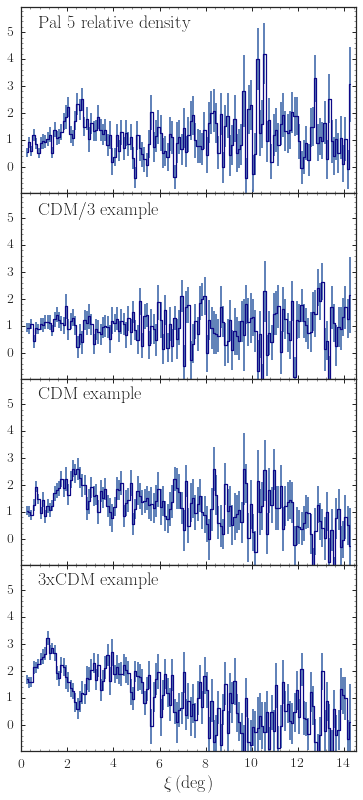

In [8]:
numpy.random.seed(10020)
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(6.,10./3.*4.)
xrange=[0.,14.5]
# First plot the data
subplot(4,1,1)
tindx= (data[:,0] > 0.2)*(data[:,0] < 14.35)
pp= Polynomial.fit(data[tindx,0],data[tindx,1]-backg,
                   deg=3,w=1./data_err[tindx,1])
bovy_plot.bovy_plot(data[tindx,0],
                    (data[tindx,1]-backg)/pp(data[tindx,0]),
                    ls='steps-mid',color=cm.plasma(0.),lw=1.25,
                    gcf=True,xrange=xrange,
                    yrange=[-.95,5.95])
errorbar(data[tindx,0],(data[tindx,1]-backg)/pp(data[tindx,0]),
         data_err[tindx,1]/pp(data[tindx,0]),
        marker='None',ls='None')
gca().xaxis.set_major_formatter(plt.NullFormatter())
bovy_plot.bovy_text(r'$\mathrm{Pal\ 5\ relative\ density}$',
                   top_left=True,size=18.)
# Few random ones
subplot(4,1,2)
xixi,tdens= read_dens(os.path.join(basefilename_pal5,'pal5_t64sampling_X10_cdmp33_6-9_dens.dat'),
                      indx=101)
tdens+= numpy.random.normal(size=len(xixi))*data_err[tindx,1]/pp(data[tindx,0])
bovy_plot.bovy_plot(xixi,tdens,
                    ls='steps-mid',color=cm.plasma(0.),lw=1.25,
                    gcf=True,xrange=xrange,
                    yrange=[-.95,5.95])
errorbar(xixi,tdens,
         data_err[tindx,1]/pp(data[tindx,0]),
        marker='None',ls='None')
gca().xaxis.set_major_formatter(plt.NullFormatter())
bovy_plot.bovy_text(r'$\mathrm{CDM/3\ example}$',top_left=True,size=18.)
subplot(4,1,3)
xixi,tdens= read_dens(os.path.join(basefilename_pal5,'pal5_t64sampling_X10_6-9_dens.dat'),
                      indx=99)
tdens+= numpy.random.normal(size=len(xixi))*data_err[tindx,1]/pp(data[tindx,0])
bovy_plot.bovy_plot(xixi,tdens,
                    ls='steps-mid',color=cm.plasma(0.),lw=1.25,
                    gcf=True,xrange=xrange,
                    yrange=[-.95,5.95])
errorbar(xixi,tdens,
         data_err[tindx,1]/pp(data[tindx,0]),
        marker='None',ls='None')
gca().xaxis.set_major_formatter(plt.NullFormatter())
bovy_plot.bovy_text(r'$\mathrm{CDM\ example}$',top_left=True,size=18.)
subplot(4,1,4)
xixi,tdens= read_dens(os.path.join(basefilename_pal5,'pal5_t64sampling_X10_cdm3_6-9_dens.dat'),
                      indx=34)
tdens+= numpy.random.normal(size=len(xixi))*data_err[tindx,1]/pp(data[tindx,0])
bovy_plot.bovy_plot(xixi,tdens,
                    ls='steps-mid',color=cm.plasma(0.),lw=1.25,
                    gcf=True,xrange=xrange,
                    yrange=[-.95,5.95],
                    xlabel=r'$\xi\,(\mathrm{deg})$')
errorbar(xixi,tdens,
         data_err[tindx,1]/pp(data[tindx,0]),
        marker='None',ls='None')
bovy_plot.bovy_text(r'$\mathrm{3xCDM\ example}$',top_left=True,size=18.)
subplots_adjust(hspace=0.)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','pal5_starcountexamples.pdf'),
                bbox_inches='tight')

Code to plot the power spectrum and bispectrum of the data:

In [9]:
def plot_dens_data(color=sns.color_palette()[0],zorder=10,marker='o',
                   poly_deg=3,minxi=0.25,
                   errsim_color=sns.color_palette()[2],errsim_zorder=0,
                   err_color=0.7,err_zorder=0,err=False):
    """Plots the power spectrum of the data"""
    # Read the data
    backg= 400.
    data= numpy.loadtxt('data/ibata_fig7b_raw.dat',delimiter=',')
    sindx= numpy.argsort(data[:,0])
    data= data[sindx]
    data_lowerr= numpy.loadtxt('data/ibata_fig7b_rawlowerr.dat',delimiter=',')
    sindx= numpy.argsort(data_lowerr[:,0])
    data_lowerr= data_lowerr[sindx]
    data_uperr= numpy.loadtxt('data/ibata_fig7b_rawuperr.dat',delimiter=',')
    sindx= numpy.argsort(data_uperr[:,0])
    data_uperr= data_uperr[sindx]
    data_err= 0.5*(data_uperr-data_lowerr)
    # CUTS
    indx= (data[:,0] > minxi-0.05)*(data[:,0] < 14.35)
    data= data[indx]
    data_lowerr= data_lowerr[indx]
    data_uperr= data_uperr[indx]
    data_err= data_err[indx]
    # Compute power spectrum
    tdata= data[:,1]-backg
    pp= Polynomial.fit(data[:,0],tdata,deg=poly_deg,w=1./data_err[:,1])
    tdata/= pp(data[:,0])
    data_err= data_err[:,1]/pp(data[:,0])
    ll= data[:,0]
    px, py= signal.csd(tdata,tdata,
                        fs=1./(ll[1]-ll[0]),scaling=scaling,
                        nperseg=len(ll))
    py= py.real
    px= 1./px
    py= numpy.sqrt(py*(ll[-1]-ll[0]))
    # Perform simulations of the noise to determine the power in the noise
    nerrsim= 10000
    ppy_err= numpy.empty((nerrsim,len(px)))
    for ii in range(nerrsim):
        tmock= data_err*numpy.random.normal(size=len(ll))
        ppy_err[ii]= signal.csd(tmock,tmock,
                                fs=1./(ll[1]-ll[0]),scaling=scaling,
                                nperseg=len(ll))[1].real
    py_err= numpy.sqrt(numpy.median(ppy_err,axis=0)*(ll[-1]-ll[0]))
    pcut= 0.4 # Only trust points above this, then remove noise
    loglog(px[py>pcut],numpy.sqrt(py[py>pcut]**2.-py_err[py>pcut]**2.),
           marker=marker,color=color,zorder=zorder,ls='none')
    errorbar(px[(py<pcut)],numpy.amax(numpy.array([py,py_err]),axis=0)[py<pcut],
             yerr=numpy.array([.1+0.*px[(py<pcut)],.1+0.*px[(py<pcut)]]),
             uplims=True,capthick=2.,ls='none',color=color,zorder=zorder)
    loglog(px,py_err,lw=2.,color=errsim_color,zorder=errsim_zorder)
    return None

In [10]:
def plot_densbispec_data(color=sns.color_palette()[0],zorder=10,marker='o',
                   poly_deg=3,minxi=0.25,ind=2,
                   errsim_color=sns.color_palette()[2],errsim_zorder=0,
                   err_color=0.7,err_zorder=0,err=False):
    """Plots the bispectrum of the data, ind=2 is ~6.5 deg"""
    # Read the data
    backg= 400.
    data= numpy.loadtxt('data/ibata_fig7b_raw.dat',delimiter=',')
    sindx= numpy.argsort(data[:,0])
    data= data[sindx]
    data_lowerr= numpy.loadtxt('data/ibata_fig7b_rawlowerr.dat',delimiter=',')
    sindx= numpy.argsort(data_lowerr[:,0])
    data_lowerr= data_lowerr[sindx]
    data_uperr= numpy.loadtxt('data/ibata_fig7b_rawuperr.dat',delimiter=',')
    sindx= numpy.argsort(data_uperr[:,0])
    data_uperr= data_uperr[sindx]
    data_err= 0.5*(data_uperr-data_lowerr)
    # CUTS
    indx= (data[:,0] > minxi-0.05)*(data[:,0] < 14.35)
    data= data[indx]
    data_lowerr= data_lowerr[indx]
    data_uperr= data_uperr[indx]
    data_err= data_err[indx]
    # Compute power spectrum
    tdata= data[:,1]-backg
    pp= Polynomial.fit(data[:,0],tdata,deg=poly_deg,w=1./data_err[:,1])
    tdata/= pp(data[:,0])
    data_err= data_err[:,1]/pp(data[:,0])
    ll= data[:,0]
    Bspec, px= bispectrum.bispectrum(numpy.vstack((tdata,tdata)).T,nfft=len(tdata),wind=7,nsamp=1,overlap=0)
    ppyr= numpy.fabs(Bspec[len(Bspec)//2+ind,len(Bspec)//2:].real)
    ppyi= numpy.fabs(Bspec[len(Bspec)//2+ind,len(Bspec)//2:].imag)
    #print 1./px[len(Bspec)//2+ind]*(ll[1]-ll[0])
    px= 1./px[len(Bspec)//2:]*(ll[1]-ll[0])
    if False:
        # Perform simulations of the noise to determine the bispectrum of the noise
        nerrsim= 1000
        ppy_err= numpy.empty((nerrsim,len(px)))
        for ii in range(nerrsim):
            tmock= data_err*numpy.random.normal(size=len(ll))
            ppy_err[ii]= signal.csd(tmock,tmock,
                                    fs=1./(ll[1]-ll[0]),scaling=scaling,
                                    nperseg=len(ll))[1].real
        py_err= numpy.sqrt(numpy.median(ppy_err,axis=0)*(ll[-1]-ll[0]))
        pcut= 0.4 # Only trust points above this, then remove noise
    subplot(1,4,1)
    loglog(px,ppyr,marker=marker,color=color,zorder=zorder,ls='none')
    subplot(1,4,2)
    loglog(px,ppyi,marker=marker,color=color,zorder=zorder,ls='none')
    #loglog(px[py>pcut],numpy.sqrt(py[py>pcut]**2.-py_err[py>pcut]**2.),
    #       marker=marker,color=color,zorder=zorder,ls='none')
    #errorbar(px[(py<pcut)],numpy.amax(numpy.array([py,py_err]),axis=0)[py<pcut],
    #         yerr=numpy.array([.1+0.*px[(py<pcut)],.1+0.*px[(py<pcut)]]),
    #         uplims=True,capthick=2.,ls='none',color=color,zorder=zorder)
    #loglog(px,py_err,lw=2.,color=errsim_color,zorder=errsim_zorder)
    return None

## A smooth-stream model in the presence of pericentric stripping

Little detour: does pericentric stripping induce significant power? Generate mock data with pericentric stripping and compute the density and power spectrum. Seems like pericentric stripping only gives a very small amount of power, mostly very close to the progenitor:

In [11]:
obs= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],
               radec=True,ro=R0,vo=V0,
               solarmotion=[-11.1,24.,7.25])
aAI= actionAngleIsochroneApprox(pot=MWPotential2014,b=0.8)
sigv= 0.5 # km/s, not actually used...
sdf_peri= \
    custom_stripping_df.streamdf_pal5_jason(sigv/V0,progenitor=obs,
                                            pot=MWPotential2014,aA=aAI,
                                            leading=False,nTrackChunks=21,
                                            nTrackIterations=1,
                                            tdisrupt=5./bovy_conversion.time_in_Gyr(V0,R0),
                                            Vnorm=V0,Rnorm=R0,R0=R0,
                                            vsun=[-11.1,V0+24.,7.25],
                                            custom_transform=pal5_util._TPAL5)

In [12]:
# Generate the density profile through sampling
nsamp= 1000000
lb_sample_trailing= sdf_peri.sample(n=nsamp,lb=True)
radec_sample_trailing= bovy_coords.lb_to_radec(lb_sample_trailing[0],
                                               lb_sample_trailing[1],
                                               degree=True)
xieta_sample_trailing= pal5_util.radec_to_pal5xieta(radec_sample_trailing[:,0],
                                                   radec_sample_trailing[:,1],
                                                   degree=True)

The stream in $(\xi,\eta)$:

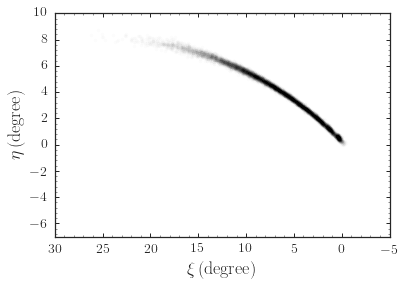

In [13]:
figsize(6,4)
bovy_plot.bovy_plot(xieta_sample_trailing[::100,0],
                    xieta_sample_trailing[::100,1],'k.',
                    alpha=0.01,zorder=0,
                    xrange=[30.,-5.],
                    yrange=[-7.,10.],
                    xlabel=r'$\xi\,(\mathrm{degree})$',
                    ylabel=r'$\eta\,(\mathrm{degree})$')

The stream's density in $\xi$:

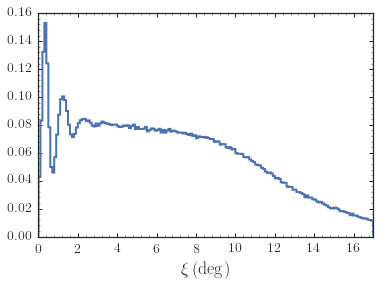

In [14]:
h,e, p= bovy_plot.bovy_hist(xieta_sample_trailing[:,0],
                            range=[0.,17.],bins=170,
                            normed=True,lw=2.,histtype='step',
                            xlabel=r'$\xi\,(\mathrm{deg})$')
sdf_peri._meandO= 0.35/bovy_conversion.freq_in_kmskpc(V0,R0)
xis= numpy.linspace(0.,17.,101)
apars= smooth_ll(xis)
dpar= numpy.array([sdf_peri.density_par(da,coord='customra') for da in apars])

In [15]:
hx= 0.5*(numpy.roll(e,-1)+e)[:-1]
def plot_peri_model(color=sns.color_palette()[0],zorder=10,marker='o',
                    poly_deg=3,minxi=0.25):
    # Read and prep data
    indx= (hx > minxi-0.05)*(hx < 14.35)
    tdata= h[indx]
    # Compute power spectrum
    pp= Polynomial.fit(hx[indx],tdata,deg=poly_deg)
    tdata/= pp(hx[indx])
    ll= hx
    px, py= signal.csd(tdata,tdata,
                       fs=1./(ll[1]-ll[0]),scaling=scaling,
                       nperseg=len(tdata))
    py= py.real
    px= 1./px
    py= numpy.sqrt(py*(ll[-1]-ll[0]))
    print py[1:3]
    loglog(px,py,marker=marker,color=color,zorder=zorder)
    return None

The power spectrum after dividing out a 3rd-order polynomial fit is very small:

[ 0.0684413   0.05941798]


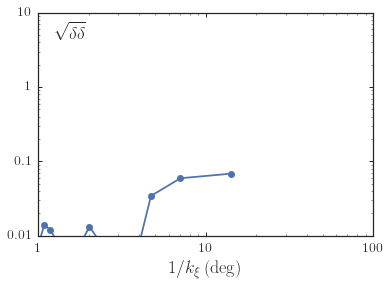

In [16]:
plot_peri_model()
set_ranges_and_labels_dens()

This amount of power is much less than the noise in the data and much less than is expected from dark-matter subhalo impacts (this level is < 1/3 CDM, see below).

## Density

In [17]:
basefilename= os.path.join(os.getenv('DATADIR'),'streamgap-pepper','pal5_multtime')

Power spectrum without continuum-normalization:

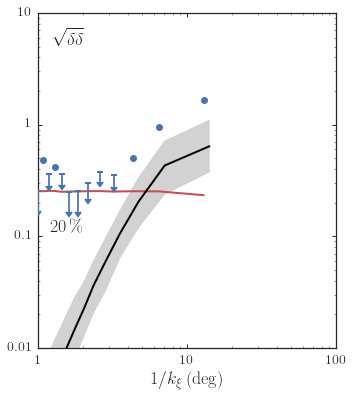

In [18]:
minxi= 0.25
poly_deg= 0
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
if save_figures:
    figsize(11/3.,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.15,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16/3.,6)
plot_dens(os.path.join(basefilename,'pal5_t64sampling_X10_6-9_dens.dat'),
          poly_deg=poly_deg,
          color='k',zorder=2,ls='-',fill=True)
plot_dens_data(poly_deg=poly_deg,minxi=minxi)
set_ranges_and_labels_dens()
bovy_plot.bovy_text(1.2,0.11,r'$20\,\%$',size=18.)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','pal5like_densObs.pdf'))

Power spectrum with continuum-normalization and with the effect of changing $\sigma_h$:

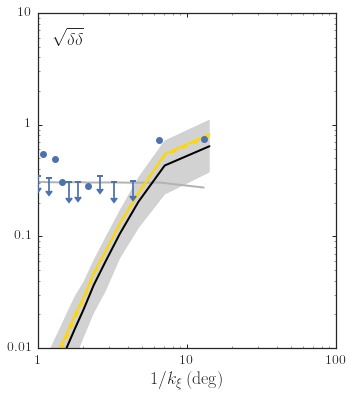

In [19]:
minxi= 0.25
poly_deg= 3
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
if save_figures:
    figsize(11/3.,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.15,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16/3.,6)
plot_dens(os.path.join(basefilename,'pal5_t64sampling_X10_6-9_dens.dat'),
          poly_deg=poly_deg,
          color='k',zorder=2,ls='-',
          fill=True)
if True:
    plot_dens(os.path.join(basefilename,'pal5_t64sampling_X10_6-9_dens.dat'),
              poly_deg=poly_deg,scale=numpy.sqrt(1.5),
              color='gold',zorder=1,ls='--')
    plot_dens(os.path.join(basefilename,'pal5_t64sampling_X10_sigma180_6-9_dens.dat'),
              poly_deg=poly_deg,
              color='gold',zorder=2,ls='-')
plot_dens_data(poly_deg=poly_deg,minxi=minxi,errsim_color='0.7')
set_ranges_and_labels_dens()

Power spectrum for different impact rates:

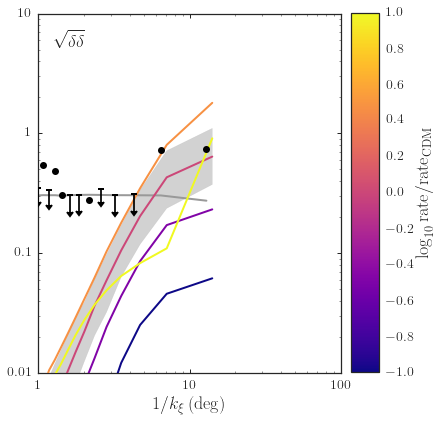

In [20]:
basefilename_pal5= os.path.join(os.getenv('DATADIR'),'streamgap-pepper','pal5_multtime')
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.plasma
minxi= 0.25
poly_deg= 3
if save_figures:
    figsize(14.5/3.,5.25)
    fig= figure()
    fig.subplots_adjust(left=0.1,right=0.75,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16/3.,6)
plot_dens(os.path.join(basefilename_pal5,'pal5_t64sampling_X10_6-9_dens.dat'),
          poly_deg=poly_deg,
          color=color_from_colormap(0.,cmap,-1,1.,),zorder=8,fill=True)
if True:
    plot_dens(os.path.join(basefilename_pal5,'pal5_t64sampling_X10_cdmp33_6-9_dens.dat'),
              poly_deg=poly_deg,
              color=color_from_colormap(numpy.log10(0.333333333),cmap,-1.,1.),zorder=9,err=None)
    plot_dens(os.path.join(basefilename_pal5,'pal5_t64sampling_X10_cdm3_6-9_dens.dat'),
              poly_deg=poly_deg,
              color=color_from_colormap(numpy.log10(3.),cmap,-1.,1.),zorder=10,err=None)
    plot_dens(os.path.join(basefilename_pal5,'pal5_t64sampling_X10_cdmp1_6-9_dens.dat'),
              poly_deg=poly_deg,
              color=color_from_colormap(-1.,cmap,-1.,1.),zorder=9,err=None)
    plot_dens(os.path.join(basefilename_pal5,'pal5_t64sampling_X10_cdm10_6-9_dens.dat'),
              poly_deg=poly_deg,
              color=color_from_colormap(1.,cmap,-1.,1.),zorder=10,err=None)
plot_dens_data(color='k',zorder=20,poly_deg=poly_deg,minxi=minxi,errsim_color='0.6')
set_ranges_and_labels_dens()
if not save_figures: tight_layout()
add_colorbar_dens(-1.,1.,r'$\log_{10} \mathrm{rate}/\mathrm{rate}_{\mathrm{CDM}}$',save_figures=save_figures)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','pal5_denspowspec.pdf'),
                bbox_inches='tight')

Power spectrum of individual mass ranges (from old runs):

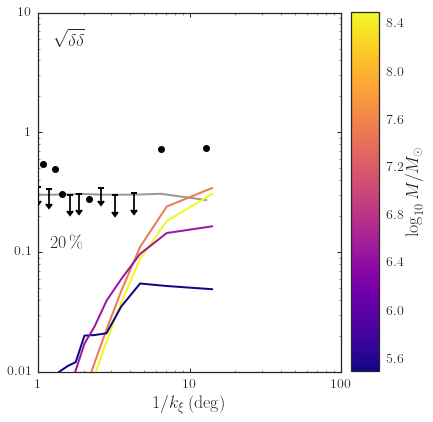

In [21]:
basefilename= os.path.join(os.getenv('DATADIR'),'streamgap-pepper','impactbpos','pal5_multtime')
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
poly_deg= 3
minxi= 0.25
cmap= cm.plasma
if save_figures:
    figsize(14.5/3.,5.25)
    fig= figure()
    fig.subplots_adjust(left=0.1,right=0.75,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16/3.,6)
plot_dens(os.path.join(basefilename,'pal5_t64sampling_X10_5.5_dens.dat'),
          poly_deg=poly_deg,ls='-',
          color=color_from_colormap(5.5,cmap,5.5,8.5),zorder=7)
plot_dens(os.path.join(basefilename,'pal5_t64sampling_X10_6.5_dens.dat'),
          poly_deg=poly_deg,ls='-',
          color=color_from_colormap(6.5,cmap,5.5,8.5),zorder=7)
plot_dens(os.path.join(basefilename,'pal5_t64sampling_X10_7.5_dens.dat'),
          poly_deg=poly_deg,ls='-',
          color=color_from_colormap(7.5,cmap,5.5,8.5),zorder=6)
plot_dens(os.path.join(basefilename,'pal5_t64sampling_X10_8.5_dens.dat'),
          poly_deg=poly_deg,ls='-',
          color=color_from_colormap(8.5,cmap,5.5,8.5),zorder=6)
plot_dens_data(color='k',zorder=20,poly_deg=poly_deg,minxi=minxi,errsim_color='0.6')
set_ranges_and_labels_dens()
bovy_plot.bovy_text(1.2,0.11,r'$20\,\%$',size=18.)
if not save_figures: tight_layout()
add_colorbar_dens(5.5,8.5,r'$\log_{10} M/M_\odot$',save_figures=save_figures)
basefilename= os.path.join(os.getenv('DATADIR'),'streamgap-pepper','pal5_multtime')

Thus, because we get a constrained on the largest *three* scales, we are plausibly sensitive to $10^{6.5}\,M_\odot$. Only considering masses down to $10^x\,M_\odot$ to constrain the rate below confirms this.

## Constrain the rate with Pal 5

In [22]:
# Do a Epanechnikov KDE estimate of the PDF in the transformed y=(1+x)/(1-x) space
def kde_epanechnikov(x,h,ydata):
    """ydata= ln[(1+xdata)/(1-xdata)]"""
    h= numpy.ones_like(x)*h
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((1.1+x)/(1.1-x))
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*(1./(1.1+x)+1./(1.1-x))

In [23]:
def plot_rate_pdf(savefilename,
                  xmax=1.5,ymax=0.15,zmax=0.2,wmax=2.,
                  b1max=0.03,b2max=0.03,
                  color=sns.color_palette()[0],zorder=8,
                  kernel_width=0.45,
                  add_limits=False,
                  overplot=False,
                  scale=1.):
    # Load results from full xi range, poly=3 and from the xi > 4, poly=0 part
    abc_full= run_pal5_abc.load_abc(savefilename)
    print("Using %i simulations to determine the rate PDF from %s" % (len(abc_full)//100,savefilename))
    # ABC:
    rate_full= abc_full[(abc_full[:,1] < xmax)*(abc_full[:,2] < ymax)*(abc_full[:,3] < zmax)*(abc_full[:,4] < wmax)\
                        *(abc_full[:,5] < b1max)*(abc_full[:,6] < b2max),0]
    xxs= numpy.linspace(-1.,1.,101)
    kdey_full= kde_epanechnikov(xxs,kernel_width,numpy.log((1.1+rate_full)/(1.1-rate_full)))\
        +numpy.random.uniform(size=len(xxs))*0.000001
    kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  
    bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot)
    if add_limits:
        # Get 95% upper limit
        cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
        uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
        # Get peak and 68% around the peak
        bf= xxs[numpy.argmax(kdey_full)]
        sindx= numpy.argsort(-kdey_full) # minus reverses sort
        cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
        m68= xxs[sindx][cp > 0.68]
        uplim68= numpy.amin(m68[m68 > bf])
        lowlim68= numpy.amax(m68[m68 < bf])
        bovy_plot.bovy_text(r'$\mathrm{rate} = %.1f^{+%.1f}_{-%.1f} \times \mathrm{CDM}\ (68\,\%%)$' \
                            % (10.**bf,10.**uplim68-10.**bf,10.**bf-10.**lowlim68)
                            +'\n'+r'$\mathrm{rate} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**uplim_95),
                           size=16.,top_left=True)
    return None
cmap= cm.plasma

Using 3000 simulations to determine the rate PDF from /Users/bovy/data/streamgap-pepper/pal5_abc_bispec/abc/pal5_t64sampling_X10_6-9_polydeg3_minxi0p25_abc.dat
Using 3000 simulations to determine the rate PDF from /Users/bovy/data/streamgap-pepper/pal5_abc_bispec/abc/pal5_t64sampling_X10_5-9_polydeg3_minxi0p25_abc.dat
Using 3000 simulations to determine the rate PDF from /Users/bovy/data/streamgap-pepper/pal5_abc_bispec/abc/pal5_t64sampling_X10_7-9_polydeg3_minxi0p25_abc.dat
Using 3000 simulations to determine the rate PDF from /Users/bovy/data/streamgap-pepper/pal5_abc_bispec/abc/pal5_t64sampling_X10_8-9_polydeg3_minxi0p25_abc.dat


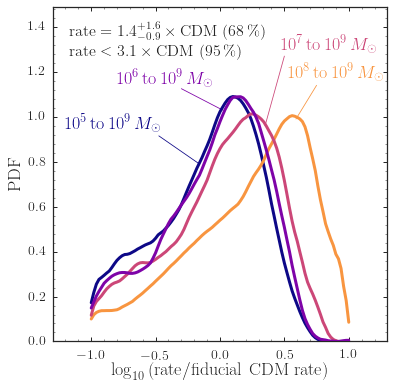

In [24]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(6.,6.)
cmap= cm.plasma
plot_rate_pdf('/Users/bovy/data/streamgap-pepper/pal5_abc_bispec/abc/pal5_t64sampling_X10_6-9_polydeg3_minxi0p25_abc.dat',
              color=color_from_colormap(6.,cmap,5.,9.),
              add_limits=True)
plot_rate_pdf('/Users/bovy/data/streamgap-pepper/pal5_abc_bispec/abc/pal5_t64sampling_X10_5-9_polydeg3_minxi0p25_abc.dat',
              color=color_from_colormap(5.,cmap,5.,9.),zorder=6,overplot=True)
plot_rate_pdf('/Users/bovy/data/streamgap-pepper/pal5_abc_bispec/abc/pal5_t64sampling_X10_7-9_polydeg3_minxi0p25_abc.dat',
              color=color_from_colormap(7.,cmap,5.,9.),zorder=7,overplot=True)
plot_rate_pdf('/Users/bovy/data/streamgap-pepper/pal5_abc_bispec/abc/pal5_t64sampling_X10_8-9_polydeg3_minxi0p25_abc.dat',
              color=color_from_colormap(8.,cmap,5.,9.),zorder=6,overplot=True)
# Label the curves
plot([0.02,-0.3],[0.84+0.19,0.935+0.19],color=color_from_colormap(6.,cmap,5.,9.),lw=.8)
bovy_plot.bovy_text(-.8,0.95+0.19,r'$10^6\,\mathrm{to}\,10^9\,M_\odot$',size=18.,
                    color=color_from_colormap(6.,cmap,5.,9.))
plot([0.35,0.5],[0.77+0.19,1.08+0.19],color=color_from_colormap(7.,cmap,5.,9.),lw=.8)
bovy_plot.bovy_text(0.47,1.1+0.19,r'$10^7\,\mathrm{to}\,10^9\,M_\odot$',size=18.,
                    color=color_from_colormap(7.,cmap,5.,9.))
plot([0.59,0.75],[0.8+0.19,0.95+0.19],color=color_from_colormap(8.,cmap,5.,9.),lw=.8)
bovy_plot.bovy_text(0.525,0.975+0.19,r'$10^8\,\mathrm{to}\,10^9\,M_\odot$',size=18.,
                    color=color_from_colormap(8.,cmap,5.,9.))
plot([-0.16,-0.475],[0.6+0.19,0.725+0.19],color=color_from_colormap(5.,cmap,5.,9.),lw=.8)
bovy_plot.bovy_text(-1.2,0.75+0.19,r'$10^5\,\mathrm{to}\,10^9\,M_\odot$',size=18.,
                    color=color_from_colormap(5.,cmap,5.,9.))
xlabel(r'$\log_{10}\left(\mathrm{rate}/\mathrm{fiducial\ CDM\ rate}\right)$')
ylabel(r'$\mathrm{PDF}$')
xlim(-1.3,1.3)
ylim(0.,1.49)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','pal5_ratepdf.pdf'),
                bbox_inches='tight')

## Track autocorrelation

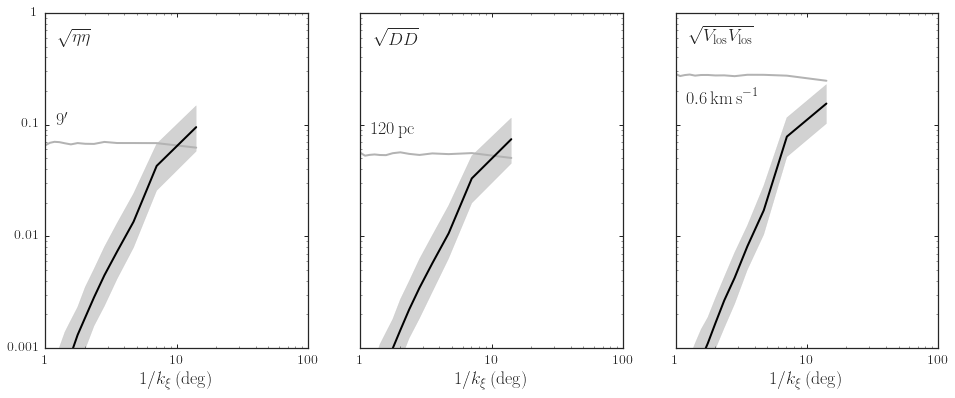

In [25]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
if save_figures:
    figsize(13,5.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.975,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
plot_all_track(os.path.join(basefilename,'pal5_t64sampling_X10_6-9_omega.dat'),
               color='k',zorder=1,ls='-',err_color='0.7',
               fill=True,errs=[0.15,0.12,0.6])
subplot(1,3,1)
bovy_plot.bovy_text(1.2,0.1,r"$9'$",size=18.)
subplot(1,3,2)
bovy_plot.bovy_text(1.2,0.08,r'$120\,\mathrm{pc}$',size=18.)
subplot(1,3,3)
bovy_plot.bovy_text(1.2,0.15,r'$0.6\,\mathrm{km\,s}^{-1}$',size=18.)
set_ranges_and_labels()

## Density-track cross-correlation

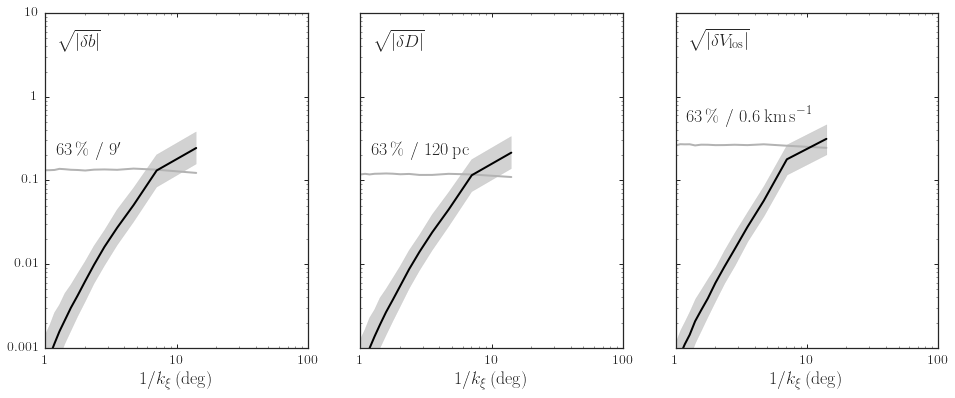

In [26]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
if save_figures:
    figsize(13,5.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.975,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
plot_all_track_dens(os.path.join(basefilename,'pal5_t64sampling_X10_6-9_dens.dat'),
                    color='k',zorder=1,ls='-',err_color='0.7',
                    fill=True,err1=0.63,err2s=[0.15,0.12,0.6])
set_ranges_and_labels_cross()
subplot(1,3,1)
bovy_plot.bovy_text(1.2,0.2,r"$63\,\%\ / \ 9'$",size=18.)
subplot(1,3,2)
bovy_plot.bovy_text(1.2,0.2,r'$63\,\%\ / \ 120\,\mathrm{pc}$',size=18.)
subplot(1,3,3)
bovy_plot.bovy_text(1.2,0.5,r'$63\,\%\ / \ 0.6\,\mathrm{km\,s}^{-1}$',size=18.)

## Bispectra

In [27]:
def median_bispectrum(filename,ind,scatter=False,limitnsim=None,err=None):
    # Compute the median bispectrum
    data1= read_data(filename)
    if 'dens' in filename:
        mOfilename= filename.replace('dens','omega')
        mOdata1= read_data(mOfilename)
    apars= data1[0]
    tdata= (data1[2:]/data1[1]).T
    nsim= len(data1)-2 # first two are apar and smooth
    if nsim < 1000:
        print "WARNING: Using fewer than 1,000 (%i) simulations to compute medians from %s" % (nsim,filename)
    if 'dens' in filename:
        ll,tdata1= convert_dens_to_obs(apars,data1[2],data1[1],mOdata1[2])
    else:
        ll,tdata1= convert_track_to_obs(apars,data1[2],1)
    Bspec, px= bispectrum.bispectrum(numpy.vstack((tdata1,tdata1)).T,nfft=len(tdata1),wind=7,nsamp=1,overlap=0)
    if not limitnsim is None: nsim= limitnsim
    ppyr= numpy.empty((nsim,len(px[len(Bspec)//2:])))
    ppyi= numpy.empty((nsim,len(px[len(Bspec)//2:])))
    ppyr_err= numpy.empty((nsim,len(px[len(Bspec)//2:])))
    ppyi_err= numpy.empty((nsim,len(px[len(Bspec)//2:])))
    for ii in range(nsim):
        if 'dens' in filename:
            ll,tdata1= convert_dens_to_obs(apars,data1[2+ii],data1[1],mOdata1[2+ii])
        else:
            ll,tdata1= convert_track_to_obs(apars,data1[2+ii],1)
        Bspec, px= bispectrum.bispectrum(numpy.vstack((tdata1,tdata1)).T,nfft=len(tdata1),wind=7,nsamp=1,overlap=0)
        ppyr[ii]= numpy.fabs(Bspec[len(Bspec)//2+ind,len(Bspec)//2:].real)
        ppyi[ii]= numpy.fabs(Bspec[len(Bspec)//2+ind,len(Bspec)//2:].imag)
        # Same for error
        if not err is None:
            tmock= err*numpy.random.normal(size=len(ll))
            Bspec, px= bispectrum.bispectrum(numpy.vstack((tmock,tmock)).T,nfft=len(tdata1),wind=7,nsamp=1,overlap=0)
            ppyr_err[ii]= numpy.fabs(Bspec[len(Bspec)//2+ind,len(Bspec)//2:].real)
            ppyi_err[ii]= numpy.fabs(Bspec[len(Bspec)//2+ind,len(Bspec)//2:].imag)
    ppyr_err.sort(axis=0)
    ppyi_err.sort(axis=0)
    if not scatter:
        return (1./px[len(Bspec)//2:]*(ll[1]-ll[0]),
                numpy.nanmedian(ppyr,axis=0),
                numpy.nanmedian(ppyi,axis=0),
                ppyr_err[int(numpy.round(0.9545*nsim))],
                ppyi_err[int(numpy.round(0.9545*nsim))])
    else:
        ppyr.sort(axis=0)
        ppyi.sort(axis=0)
        return (1./px[len(Bspec)//2:]*(ll[1]-ll[0]),
                numpy.nanmedian(ppyr,axis=0),
                numpy.nanmedian(ppyi,axis=0),
                ppyr[int(numpy.round(0.25*nsim))],
                ppyr[int(numpy.round(0.75*nsim))],
                ppyi[int(numpy.round(0.25*nsim))],
                ppyi[int(numpy.round(0.75*nsim))])

In [28]:
def plot_all_bispectrum(filename,color=sns.color_palette()[0],zorder=1,ls='-',
                        fill=False,fill_color='0.65',fill_zorder=0,
                        err_color=sns.color_palette()[2],err_zorder=0,
                        scale=1.,ind=2,nsim=None,errs=[0.63,0.15]):
    subplot(1,4,1)
    px, pyr, pyi, pyr_err, pyi_err= median_bispectrum(filename,ind,
                                                      limitnsim=nsim,err=errs[0])
    loglog(px,scale*pyr,lw=2.,color=color,zorder=zorder,ls=ls)
    if not errs[0] is None: loglog(px,scale*pyr_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    subplot(1,4,2)
    loglog(px,scale*pyi,lw=2.,color=color,zorder=zorder,ls=ls)
    if not errs[0] is None: loglog(px,scale*pyi_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        subplot(1,4,1)
        plotx, dum, dum, lowr, highr, lowi, highi= median_bispectrum(filename,ind,scatter=True,
                                                                     limitnsim=nsim)
        fill_between(plotx,scale*lowr,scale*highr,color=fill_color,zorder=fill_zorder,alpha=0.5)
        subplot(1,4,2)
        fill_between(plotx,scale*lowi,scale*highi,color=fill_color,zorder=fill_zorder,alpha=0.5)
    subplot(1,4,3)
    px, pyr, pyi, pyr_err, pyi_err= median_bispectrum(filename.replace('dens','omega'),ind,
                                                      limitnsim=nsim,err=errs[1])
    loglog(px,100.*pyr,lw=2.,color=color,zorder=zorder,ls=ls)
    if not errs[0] is None: loglog(px,100.*pyr_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    subplot(1,4,4)
    loglog(px,100.*pyi,lw=2.,color=color,zorder=zorder,ls=ls)
    if not errs[0] is None: loglog(px,100.*pyi_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        subplot(1,4,3)
        plotx, dum, dum, lowr, highr, lowi, highi= median_bispectrum(filename.replace('dens','omega'),
                                                                     ind,scatter=True,limitnsim=nsim)
        fill_between(plotx,100.*lowr,100.*highr,color=fill_color,zorder=fill_zorder,alpha=0.5)
        subplot(1,4,4)
        fill_between(plotx,100.*lowi,100.*highi,color=fill_color,zorder=fill_zorder,alpha=0.5)
    return None
def set_ranges_and_labels_bispectrum(high=20.):
    subplot(1,4,1)
    bovy_plot.bovy_text(r'$|\mathrm{Real}(\delta\delta\delta)|$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$')
    ylim(0.0001,high)
    xlim(1.,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    subplot(1,4,2)
    bovy_plot.bovy_text(r'$|\mathrm{Imag}(\delta\delta\delta)|$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$')
    ylim(0.0001,high)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    subplot(1,4,3)
    bovy_plot.bovy_text(r'$|\mathrm{Real}(bbb)|$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$')
    ylim(0.0001,high)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    subplot(1,4,4)
    bovy_plot.bovy_text(r'$|\mathrm{Imag}(bbb)|$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$')
    ylim(0.0001,high)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    return None
def add_colorbar_bispectrum(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.925)
        cbar_ax = fig.add_axes([0.99, 0.13, 0.025, 0.845])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None

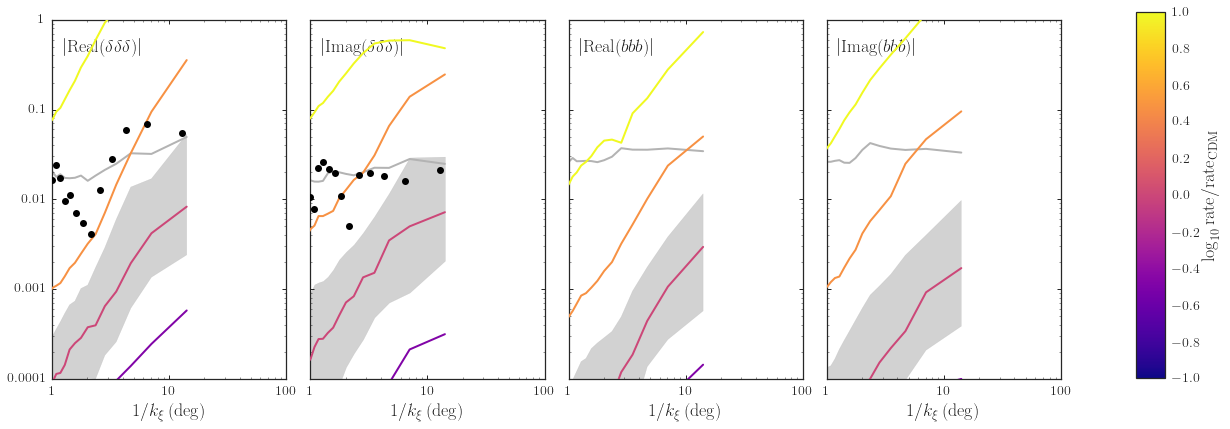

In [29]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(16,6)
poly_deg= 3
minxi= 0.25
cmap= cm.plasma
if save_figures:
    figsize(12,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.1)
else:
    figsize(16,6)
plot_all_bispectrum(os.path.join(basefilename,'pal5_t64sampling_X10_6-9_dens.dat'),
                    color=color_from_colormap(0.,cmap,-1,1.,),zorder=8,fill=True,nsim=101,
                    err_color='0.7')
if True:
    plot_all_bispectrum(os.path.join(basefilename,'pal5_t64sampling_X10_cdmp33_6-9_dens.dat'),
                        color=color_from_colormap(numpy.log10(0.333333333),cmap,-1.,1.),zorder=9,nsim=101,
                        errs=[None,None])
    plot_all_bispectrum(os.path.join(basefilename,'pal5_t64sampling_X10_cdm3_6-9_dens.dat'),
                        color=color_from_colormap(numpy.log10(3.),cmap,-1.,1.),zorder=10,nsim=101,
                        errs=[None,None])
    plot_all_bispectrum(os.path.join(basefilename,'pal5_t64sampling_X10_cdmp1_6-9_dens.dat'),
                        color=color_from_colormap(-1.,cmap,-1.,1.),zorder=9,nsim=None,
                        errs=[None,None])
    plot_all_bispectrum(os.path.join(basefilename,'pal5_t64sampling_X10_cdm10_6-9_dens.dat'),
                        color=color_from_colormap(1.,cmap,-1.,1.),zorder=10,nsim=101,
                        errs=[None,None])
plot_densbispec_data(color='k',zorder=20,poly_deg=poly_deg,minxi=minxi,errsim_color='0.6')
set_ranges_and_labels_bispectrum(high=1.)
if not save_figures: tight_layout()
add_colorbar_bispectrum(-1.,1.,r'$\log_{10} \mathrm{rate}/\mathrm{rate}_{\mathrm{CDM}}$',save_figures=save_figures)

# Analysis of Pal 5 simulations w/ varying amounts of substructure

In [30]:
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','pal_5_realizations',
                                 'pal_5_no_subhaloes_501.txt'))
xv_unp= xvid[:,:6]
xv_unp= xv_unp[numpy.argsort(xvid[:,6])]
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','pal_5_realizations',
                                 'pal_5_10x_lcdm_1e6_1e9_480.txt'))
xv_10xCDM= xvid[:,:6]
xv_10xCDM= xv_10xCDM[numpy.argsort(xvid[:,6])]
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','pal_5_realizations',
                                 'pal_5_3x_lcdm_1e6_1e9_505.txt'))
xv_3xCDM= xvid[:,:6]
xv_3xCDM= xv_3xCDM[numpy.argsort(xvid[:,6])]
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','pal_5_realizations',
                                 'pal_5_lcdm_1e6_1e9_501.txt'))
xv_1xCDM= xvid[:,:6]
xv_1xCDM= xv_1xCDM[numpy.argsort(xvid[:,6])]

In [31]:
def convert_sim_to_pal5obs(xv):
    XYZ= bovy_coords.galcenrect_to_XYZ(xv[:,0],xv[:,1],xv[:,2],Xsun=R0,Zsun=0.025).T
    vXYZ= bovy_coords.galcenrect_to_vxvyvz(xv[:,3],xv[:,4],xv[:,5],vsun=[-11.1,V0+24.,7.25]).T
    lbd= bovy_coords.XYZ_to_lbd(XYZ[0],XYZ[1],XYZ[2],degree=True)
    vrpm= bovy_coords.vxvyvz_to_vrpmllpmbb(vXYZ[0],vXYZ[1],vXYZ[2],
                                          lbd[:,0],lbd[:,1],lbd[:,2],degree=True)
    radec= bovy_coords.lb_to_radec(lbd[:,0],lbd[:,1],degree=True)
    xieta= pal5_util.radec_to_pal5xieta(radec[:,0],radec[:,1],degree=True)
    # make sure the progenitor is at (0,0)
    return (xieta[:,0]-numpy.median(xieta[:,0]),xieta[:,1]-numpy.median(xieta[:,1]))

In [32]:
xieta_unp= convert_sim_to_pal5obs(xv_unp)
xieta_1xCDM= convert_sim_to_pal5obs(xv_1xCDM)
xieta_3xCDM= convert_sim_to_pal5obs(xv_3xCDM)
xieta_10xCDM= convert_sim_to_pal5obs(xv_10xCDM)

Location of the mock streams on the sky:

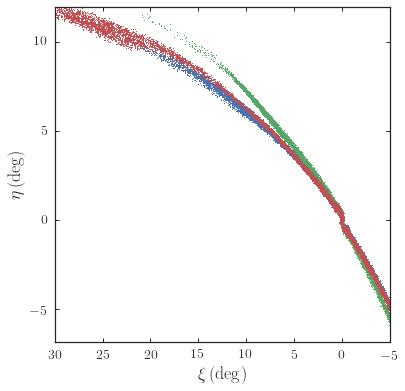

In [33]:
figsize(6,6)
plot(xieta_unp[0],xieta_unp[1],',',color=sns.color_palette()[0])
plot(xieta_1xCDM[0],xieta_1xCDM[1],',',color=sns.color_palette()[1])
plot(xieta_3xCDM[0],xieta_3xCDM[1],',',color=sns.color_palette()[2])
xlim(30.,-5.)
ylim(-6.8,12.)
xlabel(r'$\xi\,(\mathrm{deg})$')
ylabel(r'$\eta\,(\mathrm{deg})$')

Densities, densities+polynomial fit, and normalized densities:

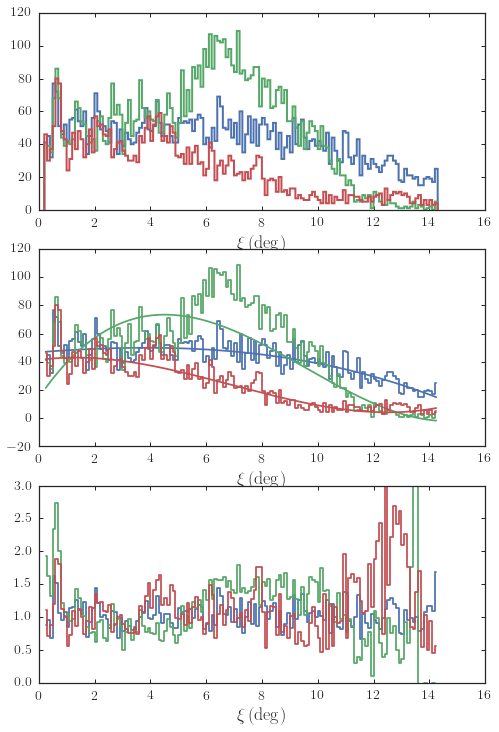

In [34]:
figsize(8,12)
subplot(3,1,1)
hu,eu,p= hist(xieta_unp[0],range=[0.2,14.3],bins=141,histtype='step',lw=2.)
h1,e,p= hist(xieta_1xCDM[0],range=[0.2,14.3],bins=141,histtype='step',lw=2.)
h,e,p= hist(xieta_3xCDM[0],range=[0.2,14.3],bins=141,histtype='step',lw=2.)
x= numpy.arange(0.25,14.35,0.1)
xlabel(r'$\xi\,(\mathrm{deg})$')
subplot(3,1,2)
pp= Polynomial.fit(x,hu,deg=3,w=1./numpy.sqrt(hu))
plot(x,hu,ls='steps-mid',color=sns.color_palette()[0])
plot(x,pp(x),ls='-',color=sns.color_palette()[0])
pp= Polynomial.fit(x,h1,deg=3,w=1./numpy.sqrt(h1+2.))
plot(x,h1,ls='steps-mid',color=sns.color_palette()[1])
plot(x,pp(x),ls='-',color=sns.color_palette()[1])
pp= Polynomial.fit(x,h,deg=3,w=1./numpy.sqrt(h))
plot(x,h,ls='steps-mid',color=sns.color_palette()[2])
plot(x,pp(x),ls='-',color=sns.color_palette()[2])
xlabel(r'$\xi\,(\mathrm{deg})$')
subplot(3,1,3)
pp= Polynomial.fit(x,hu,deg=3,w=1./numpy.sqrt(hu))
plot(x,hu/pp(x),ls='steps-mid',color=sns.color_palette()[0])
pp= Polynomial.fit(x,h1,deg=3,w=1./numpy.sqrt(h1+2.))
plot(x,h1/pp(x),ls='steps-mid',color=sns.color_palette()[1])
pp= Polynomial.fit(x,h,deg=3,w=1./numpy.sqrt(h))
plot(x,h/pp(x),ls='steps-mid',color=sns.color_palette()[2])
ylim(-0.,3.)
xlabel(r'$\xi\,(\mathrm{deg})$')

In [35]:
# Compute power spectrum
def plot_sim_powspec(x,h):
    import copy
    tdata= copy.deepcopy(h)
    pp= Polynomial.fit(x,h,deg=2,w=1./numpy.sqrt(h+1.))
    tdata/= pp(x)
    ll= x
    px, py= signal.csd(tdata,tdata,
                       fs=1./(ll[1]-ll[0]),scaling=scaling,
                       nperseg=len(ll))
    py= py.real
    px= 1./px
    py= numpy.sqrt(py*(ll[-1]-ll[0]))
    loglog(px,py,'o')

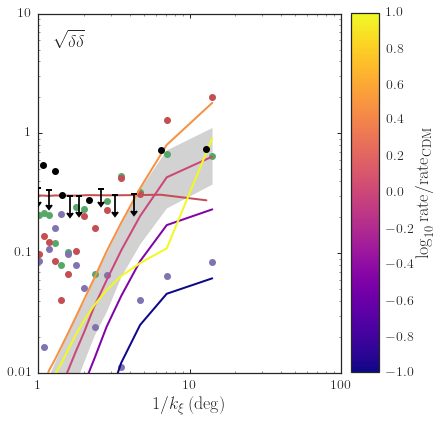

In [36]:
basefilename_pal5= os.path.join(os.getenv('DATADIR'),'streamgap-pepper','pal5_multtime')
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.plasma
minxi= 0.25
poly_deg= 3
if save_figures:
    figsize(14.5/3.,5.25)
    fig= figure()
    fig.subplots_adjust(left=0.1,right=0.75,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16/3.,6)
plot_dens(os.path.join(basefilename_pal5,'pal5_t64sampling_X10_6-9_dens.dat'),
          poly_deg=poly_deg,
          color=color_from_colormap(0.,cmap,-1,1.,),zorder=8,fill=True)
if True:
    plot_dens(os.path.join(basefilename_pal5,'pal5_t64sampling_X10_cdmp33_6-9_dens.dat'),
              poly_deg=poly_deg,
              color=color_from_colormap(numpy.log10(0.333333333),cmap,-1.,1.),zorder=9,err=None)
    plot_dens(os.path.join(basefilename_pal5,'pal5_t64sampling_X10_cdm3_6-9_dens.dat'),
              poly_deg=poly_deg,
              color=color_from_colormap(numpy.log10(3.),cmap,-1.,1.),zorder=10,err=None)
    plot_dens(os.path.join(basefilename_pal5,'pal5_t64sampling_X10_cdmp1_6-9_dens.dat'),
              poly_deg=poly_deg,
              color=color_from_colormap(-1.,cmap,-1.,1.),zorder=9,err=None)
    plot_dens(os.path.join(basefilename_pal5,'pal5_t64sampling_X10_cdm10_6-9_dens.dat'),
              poly_deg=poly_deg,
              color=color_from_colormap(1.,cmap,-1.,1.),zorder=10,err=None)
plot_dens_data(color='k',zorder=20,poly_deg=poly_deg,minxi=minxi)
plot_sim_powspec(x,h)
plot_sim_powspec(x,h1)
plot_sim_powspec(x,hu)
set_ranges_and_labels_dens()
if not save_figures: tight_layout()
add_colorbar_dens(-1.,1.,r'$\log_{10} \mathrm{rate}/\mathrm{rate}_{\mathrm{CDM}}$',save_figures=save_figures)

Using 3000 simulations to determine the rate PDF from /Users/bovy/data/streamgap-pepper/pal5_mockcdm_abc_wreal_bispec/abc/pal5_t64sampling_X10_6-9_polydeg3_minxi0p25_abc.dat
Using 3000 simulations to determine the rate PDF from /Users/bovy/data/streamgap-pepper/pal5_mock_abc_wreal_bispec/abc/pal5_t64sampling_X10_6-9_polydeg3_minxi0p25_abc.dat
Using 3000 simulations to determine the rate PDF from /Users/bovy/data/streamgap-pepper/pal5_mockunp_abc_wreal_bispec/abc/pal5_t64sampling_X10_6-9_polydeg3_minxi0p25_abc.dat


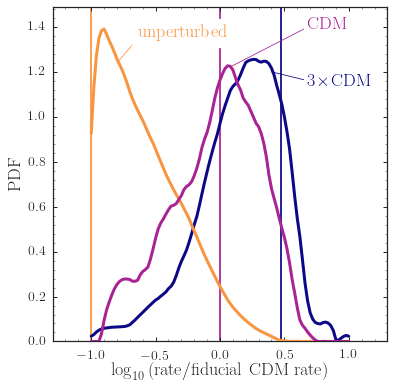

In [37]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(6.,6.)
cmap= cm.plasma
plot_rate_pdf('/Users/bovy/data/streamgap-pepper/pal5_mockcdm_abc_wreal_bispec/abc/pal5_t64sampling_X10_6-9_polydeg3_minxi0p25_abc.dat',
              color=color_from_colormap(6.5,cmap,5.,9.),scale=1.,b1max=0.2,b2max=0.1)
plot_rate_pdf('/Users/bovy/data/streamgap-pepper/pal5_mock_abc_wreal_bispec/abc/pal5_t64sampling_X10_6-9_polydeg3_minxi0p25_abc.dat',
              color=color_from_colormap(5.,cmap,5.,9.),zorder=6,overplot=True,b1max=0.1,b2max=0.05)
plot_rate_pdf('/Users/bovy/data/streamgap-pepper/pal5_mockunp_abc_wreal_bispec/abc/pal5_t64sampling_X10_6-9_polydeg3_minxi0p25_abc.dat',
              color=color_from_colormap(8.,cmap,5.,9.),zorder=7,overplot=True,scale=0.9)
# Truth
axvline(0.,color=color_from_colormap(6.5,cmap,5.,9.),zorder=0)
axvline(numpy.log10(3.),color=color_from_colormap(5.,cmap,5.,9.),zorder=0)
axvline(-1.,color=color_from_colormap(8.,cmap,5.,9.),zorder=0)
# Label the curves
plot([0.4,0.65],[1.2,0.925+0.24],color=color_from_colormap(5.,cmap,5.,9.),lw=.8)
bovy_plot.bovy_text(0.675,0.9+0.24,r'$3\!\times\!\mathrm{CDM}$',size=18.,
                    color=color_from_colormap(5.,cmap,5.,9.))
plot([0.09,0.65],[1.225,1.15+0.24],color=color_from_colormap(6.5,cmap,5.,9.),lw=.8)
bovy_plot.bovy_text(0.675,1.15+0.24,r'$\mathrm{CDM}$',size=18.,
                    color=color_from_colormap(6.5,cmap,5.,9.))
plot([-0.8,-0.65],[1.+0.24,1.1+0.24],color=color_from_colormap(8.,cmap,5.,9.),lw=.8)
bovy_plot.bovy_text(-0.635,1.11+0.24,r'$\mathrm{unperturbed}$',size=18.,
                    color=color_from_colormap(8.,cmap,5.,9.),backgroundcolor='w')
xlabel(r'$\log_{10}\left(\mathrm{rate}/\mathrm{fiducial\ CDM\ rate}\right)$')
ylabel(r'$\mathrm{PDF}$')
xlim(-1.3,1.3)
ylim(0.,1.49)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','mockpal5_ratepdf.pdf'),
                bbox_inches='tight')